In [2]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [3]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import matplotlib as mpl
import src.utils.plotting as plotting
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec
import polars.selectors as cs

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

polars.config.Config

In [4]:
exp_name = "0332-92xkckqk"
df_raw = read_logs(exp_name=exp_name, exp_path=None)

In [5]:
df_raw = df_raw.with_columns(cs.contains("time_join").fill_null(0))

In [6]:
# df_raw = pl.read_csv("/home/soda/rcappuzz/work/benchmark-join-suggestions/results/logs/0347-dkqk2xod/run_logs/0.log")
df_raw = read_logs(exp_name="0347-dkqk2xod", exp_path=None)
df_raw = df_raw.fill_null(0)

In [7]:
chosen_model = "linear"
results = (
    df_raw.filter(pl.col("chosen_model") == chosen_model)
    .group_by("estimator")
    .agg(
        # pl.col("time_fit").mean(),
        # pl.col("time_predict").mean(),
        # pl.col("time_run").mean(),
        pl.col("time_prepare").mean(),
        pl.col("time_model_train").mean(),
        pl.col("time_join_train").mean(),
        pl.col("time_model_predict").mean(),
        pl.col("time_join_predict").mean(),
    )
    .melt(id_vars="estimator")
)

In [8]:
dicts = results.group_by("estimator").agg(pl.all()).to_dicts()

In [9]:
to_concat = []
for _, gr in results.group_by("estimator"):
    new_g = (
        gr.sort("variable")
        .with_columns(pl.col("value").cumsum().alias("csum"))
        .with_columns(
            pl.col("csum").alias("bottom").shift(1).fill_null(0),
        )
    )
    to_concat.append(new_g)
df_c = pl.concat(to_concat)

In [10]:
dicts = df_c.group_by("variable").agg(pl.all()).sort("variable").to_dicts()

In [11]:
df_c.group_by("variable").agg(pl.all()).sort("variable")

variable,estimator,value,csum,bottom
str,list[str],list[f64],list[f64],list[f64]
"""time_join_predict""","[""stepwise_greedy_join"", ""highest_containment"", … ""best_single_join""]","[77.443126, 13.61349, … 9.178508]","[77.443126, 13.61349, … 9.178508]","[0.0, 0.0, … 0.0]"
"""time_join_train""","[""stepwise_greedy_join"", ""highest_containment"", … ""best_single_join""]","[129.128275, 13.678565, … 206.320802]","[206.5714, 27.292055, … 215.49931]","[77.443126, 13.61349, … 9.178508]"
"""time_model_predict""","[""stepwise_greedy_join"", ""highest_containment"", … ""best_single_join""]","[0.13601, 0.048388, … 0.033812]","[206.70741, 27.340443, … 215.533122]","[206.5714, 27.292055, … 215.49931]"
"""time_model_train""","[""stepwise_greedy_join"", ""highest_containment"", … ""best_single_join""]","[84.78944, 0.411973, … 3.213439]","[291.496851, 27.752416, … 218.746561]","[206.70741, 27.340443, … 215.533122]"
"""time_prepare""","[""stepwise_greedy_join"", ""highest_containment"", … ""best_single_join""]","[4.922772, 3.603475, … 0.065047]","[296.419623, 31.355891, … 218.811608]","[291.496851, 27.752416, … 218.746561]"


time_join_predict
[77.4431255423729, 13.61349038983051, 0.0, 94.0133927457627, 9.178507745762712]
time_join_train
[206.57140006779662, 27.29205544067797, 0.0, 187.9995151694915, 215.49930961016946]
time_model_predict
[206.7074102542373, 27.34044318644068, 0.021930966666666663, 188.16775815254235, 215.53312198305082]
time_model_train
[291.4968507118644, 27.752415881355933, 0.06956066666666669, 191.0354495932203, 218.74656108474574]
time_prepare
[296.419623, 31.355891305084747, 0.07181043333333335, 191.03943037288133, 218.81160771186438]


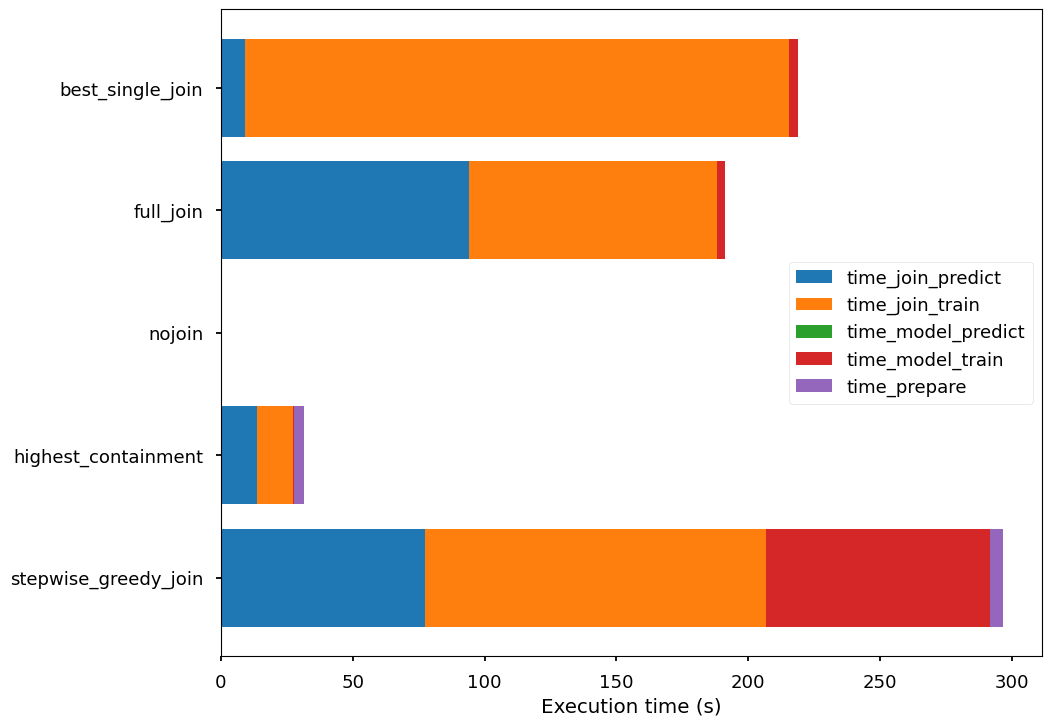

In [12]:
fig, axs = plt.subplots(squeeze=True, layout="constrained")
for idx, d in enumerate(dicts):
    print(d["variable"])
    print(d["csum"])
    p = axs.barh(
        y=d["estimator"], width=d["value"], left=d["bottom"], label=d["variable"]
    )
    # axs.bar_label(p,)
axs.legend()
axs.set_xlabel("Execution time (s)")
fig.savefig(f"images/time_spent_{chosen_model}.png")

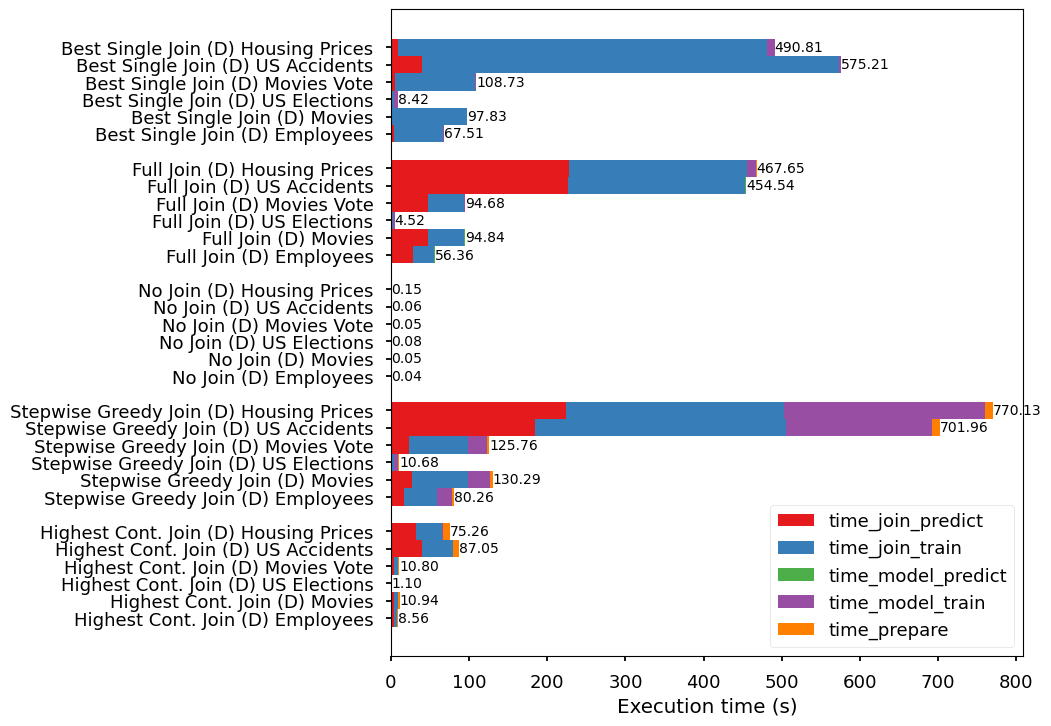

In [17]:
plotting.prepare_grouped_stacked_barplot_time(df_raw.filter(pl.col("chosen_model") == "linear"), "estimator", "base_table")

# Memory footprint

In [30]:
df_mem = df_raw.select(
    pl.col("estimator"),
    pl.col("chosen_model"),
    pl.col("peak_fit"),
    pl.col("peak_predict"),
    # pl.col("peak_test"),
).melt(id_vars=["estimator", "chosen_model"])

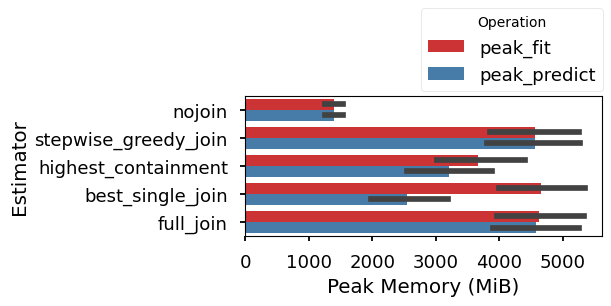

In [47]:
fig, ax = plt.subplots(figsize=(6, 3), layout="constrained")
sns.barplot(data=df_mem.to_pandas(), x="value", y="estimator", hue="variable", palette="Set1", ax=ax)
ax.set_xlabel("Peak Memory (MiB)")
ax.set_ylabel("Estimator")
h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(h, l, title="Operation", loc="outside upper right")
fig.savefig("images/memory_usage.pdf")
